<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/hierarchical_forecasting_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical reconciliation revised
In this notebook we will:
1. download the m4 competition dataset
2. use the first 8 series to build a 3-level hierarchy
3. produce base forecasts for all the signal of the hierarchy separately, using autoARIMA
4. build the summation matrix s
5. write reconciliation code from scratch
6. reconcile the forecasts on the test set

In [2]:
#@title Install and import packages
%%capture
!pip install wget
!pip install statsforecast==1.7.3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import wget

# 1: Data retrieval

In [3]:
#@title data retrieval and preprocess
wget.download("https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv", 'm4_h.csv')
wget.download("https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv", 'm4_h_te.csv')

# data preprocessing
df_tr = pd.read_csv('m4_h.csv')
df_te = pd.read_csv('m4_h_te.csv').rename(columns={'y': 'y_test'})

n_series = 8
uids = df_tr['unique_id'].unique()[:n_series]
df_tr = df_tr.query('unique_id in @uids')
df_te = df_te.query('unique_id in @uids')
stds = {uid: df_tr.query('unique_id == @uid')['y'].std() for uid in uids}
means = {uid: df_tr.query('unique_id == @uid')['y'].mean() for uid in uids}
# standardize data in df_tr and df_te
for uid in uids:
    y = (df_tr.loc[df_tr['unique_id'] == uid, 'y'] - means[uid])/stds[uid]
    df_tr.loc[df_tr['unique_id'] == uid, 'y'] = y - y.min()
    df_te.loc[df_te['unique_id'] == uid, 'y_test'] = (df_te.loc[df_te['unique_id'] == uid, 'y_test'] - means[uid])/stds[uid]- y.min()

df_dummy_tr = df_tr.query('unique_id == "H1"').copy()
df_dummy_te = df_te.query('unique_id == "H1"').copy()
df_tr.head()

,unique_id,ds,y
0,H1,1,1.626986
1,H1,2,1.506233
2,H1,3,1.506233
3,H1,4,1.334637
4,H1,5,1.029577


# 2: Define a hierarchy and aggregate signals

<Axes: xlabel='ds'>

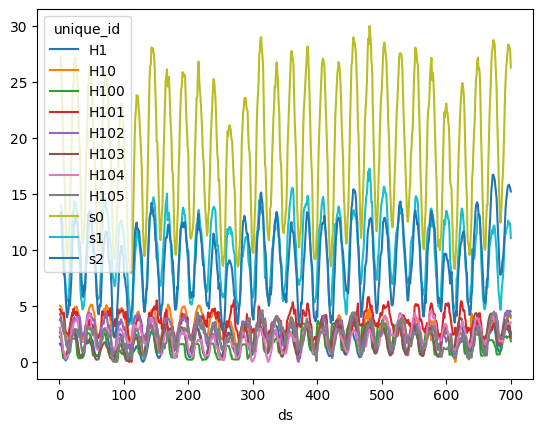

In [4]:

# create aggregations from the bottom time series
groups = {  's0':uids,
            's1':uids[:4],
            's2': uids[4:]
          }

for name, g in groups.items():
    df_dummy_tr['unique_id'] = name
    df_dummy_te['unique_id'] = name
    df_dummy_tr['y'] = df_tr.query('unique_id in @g').pivot(columns='unique_id', values='y', index='ds').sum(axis=1)
    df_tr = pd.concat([df_tr, df_dummy_tr], axis=0)
    df_dummy_te['y_test'] = df_te.query('unique_id in @g').pivot(columns='unique_id', values='y_test', index='ds').sum(axis=1).reset_index(drop=True)
    df_te = pd.concat([df_te, df_dummy_te], axis=0)

df_tr.reset_index(drop=True).pivot(columns='unique_id', values='y', index='ds').plot()


#3: Produce base forecasts


In [5]:
from statsforecast.models import AutoARIMA

# create a df where to store forecasts
df_hat = df_te.copy()
df_hat['y_test'] = 0

# fit a separate model for each TS
for uid in tqdm(df_tr['unique_id'].unique()):
  model = AutoARIMA(season_length=24,approximation=True).fit(df_tr.query('unique_id == @uid')['y'].values)
  df_hat.loc[df_hat['unique_id'] == uid, 'y_test'] = model.predict(48)['mean']


100%|██████████| 11/11 [01:57<00:00, 10.64s/it]


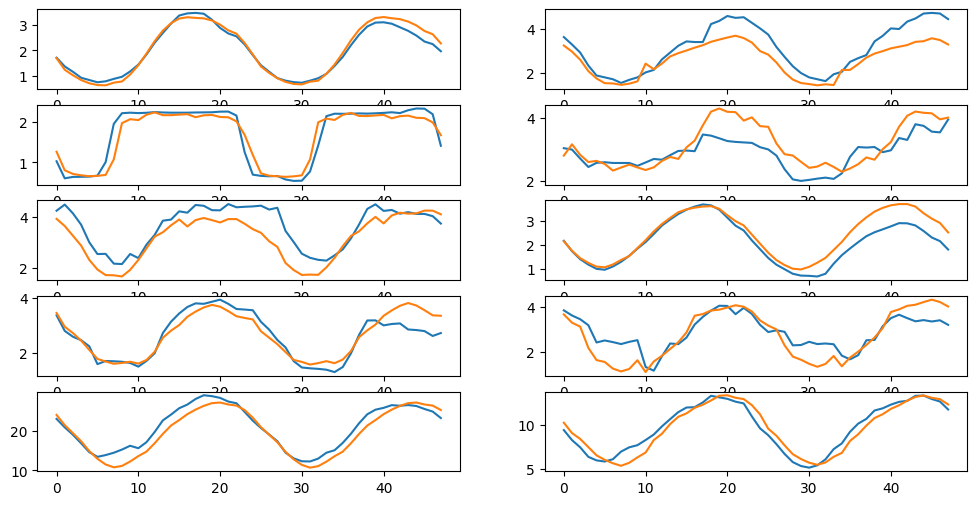

In [6]:
# plot forecasts and actual signals
fig, ax = plt.subplots(5, 2, figsize=(12, 6))
for uid, a in zip(df_te['unique_id'].unique(), ax.ravel()):
    y_te = df_te.loc[df_te['unique_id'] == uid, 'y_test'].reset_index(drop=True)
    y_hat_s = df_hat.loc[df_hat['unique_id'] == uid, 'y_test'].reset_index(drop=True)
    y_te.plot(ax=a)
    y_hat_s.plot(ax=a)

In [24]:
print(model.model_['arma'])
print(model.model_['coef'])


(1, 1, 2, 1, 24, 0, 1)
{'ar1': 0.7369185121854379, 'ma1': 0.13310409888943972, 'sar1': -0.03297532214815891, 'sar2': -0.17368167604992082, 'sma1': -0.7756249277498524}


We put the forecasts in a wide format df and reorder the columns so that the aggregations are the first columns

In [8]:

y_hat = df_hat.pivot(columns='unique_id', values='y_test', index='ds')
y_hat = y_hat[np.hstack([['s0', 's1', 's2'], uids])]
y_test = df_te.pivot(columns='unique_id', values='y_test', index='ds')
y_test = y_test[np.hstack([['s0', 's1', 's2'], uids])]


# 4: Build summation matrix

In [9]:
agg_matrix = np.vstack([[1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 1, 1, 1]])
s_matrix = np.vstack([agg_matrix, np.eye(len(uids))])


# 5: Write reconciliation code

In [10]:

from sklearn.covariance import ShrunkCovariance


def estimate_covariance(x):
    cov = ShrunkCovariance().fit(x)
    return cov.covariance_, cov.precision_


def get_g_matrix(y, y_hat, s_matrix):
    errs = y - y_hat
    cov, precision = estimate_covariance(errs.values)
    # reconciliation with orthogonal projection
    # g_matrix = np.linalg.inv(s_matrix.T @ s_matrix) @ (s_matrix.T )
    # reconciliation with non-orthogonal projection
    g_matrix = np.linalg.inv(s_matrix.T @ precision @ s_matrix) @ (s_matrix.T @ precision)
    return g_matrix


def reconcile(y, y_hat, s_matrix):
    g_matrix = get_g_matrix(y, y_hat, s_matrix)
    y_tilde = (s_matrix @ g_matrix @ y_hat.T).T
    y_tilde.columns = y.columns
    return y_tilde

# 6: Reconcile the forecasts

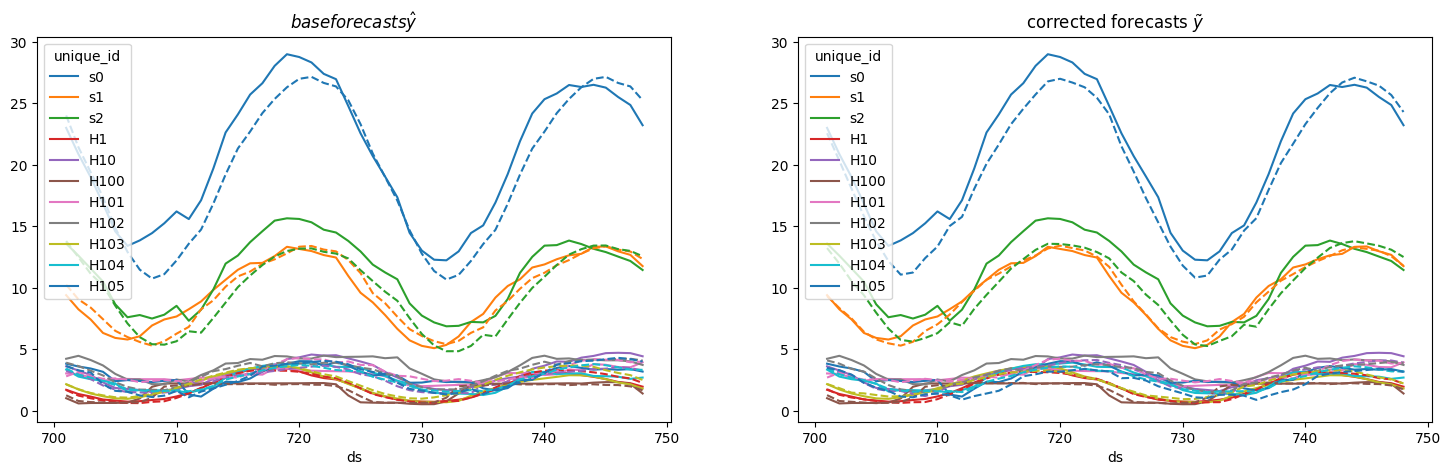

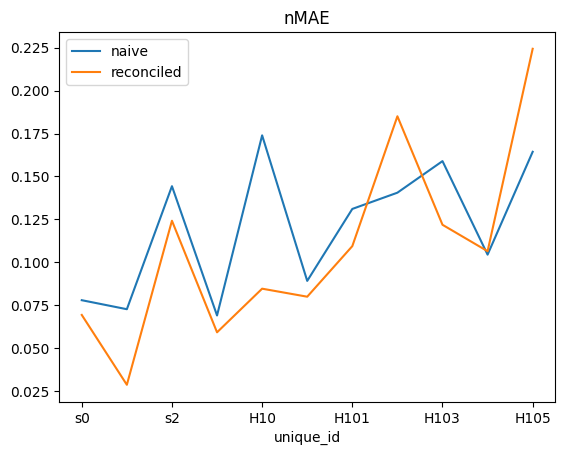

mean NMAE naive: 1.21e-01
mean NMAE reconciled: 1.09e-01


In [27]:
# reconcile forecasts
y_tilde = reconcile(y_test, y_hat, s_matrix)

# plot naive and reconciled
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
ll = y_test.plot(ax=ax[0])
colors = [l._color for l in ll.lines]
[ax[0].plot(y_hat[uid], color=c, linestyle='--') for uid, c in zip(y_hat.columns, colors)]
ax[0].set_title(r'$base forecasts \hat{y}$')
y_test.plot(ax=ax[1])
[ax[1].plot(y_tilde[uid], color=c, linestyle='--') for uid, c in zip(y_tilde.columns, colors)]
ax[1].set_title(r'corrected forecasts $\tilde{y}$')

# retrieve nMAE
nmae = lambda y, y_hat: np.sum(np.abs(y_hat-y), axis=0)/np.sum(np.abs(y), axis=0)
plt.figure()
nmae(y_test, y_hat).plot(label='naive')
nmae(y_test, y_tilde).plot(label='reconciled')
plt.legend()
plt.title('nMAE')

plt.pause(1)
print('mean NMAE naive: {:0.2e}'.format(nmae(y_test, y_hat).mean()))
print('mean NMAE reconciled: {:0.2e}'.format(nmae(y_test, y_tilde).mean()))
